In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-11-26 14:50:09.543821: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:50:09.581636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 14:50:09.581708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 14:50:09.583474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 14:50:09.589348: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:50:09.590326: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [14]:
# Load data
df = pd.read_csv('ETH-USD.csv')

features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

In [15]:

# Create a dataset with X (input) and y (output) for time series
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        y.append(dataset[i + time_step, -2])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [17]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 5)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 5)

In [18]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
38/38 [==============================] - 4s 40ms/step - loss: 0.0066
Epoch 2/100
38/38 [==============================] - 2s 40ms/step - loss: 0.0015
Epoch 3/100
38/38 [==============================] - 2s 40ms/step - loss: 0.0013
Epoch 4/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0012
Epoch 5/100
38/38 [==============================] - 2s 41ms/step - loss: 0.0012
Epoch 6/100
38/38 [==============================] - 2s 48ms/step - loss: 0.0010
Epoch 7/100
38/38 [==============================] - 2s 46ms/step - loss: 8.8178e-04
Epoch 8/100
38/38 [==============================] - 2s 40ms/step - loss: 0.0011
Epoch 9/100
38/38 [==============================] - 1s 38ms/step - loss: 0.0011
Epoch 10/100
38/38 [==============================] - 1s 39ms/step - loss: 7.8924e-04
Epoch 11/100
38/38 [==============================] - 1s 38ms/step - loss: 7.7408e-04
Epoch 12/100
38/38 [==============================] - 1s 38ms/step - loss: 7.1386e-04
Epoch 13/

In [49]:
# Predict on test data
predictions = model.predict(X_train[-time_step:])
p = np.zeros((100, 5))
p[:, 0] = predictions[:, 0]
predictions = p
predictions = scaler.inverse_transform(predictions)[:, 0]

4/4 [==============================] - 0s 27ms/step


In [50]:
# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ', rmse)

ValueError: operands could not be broadcast together with shapes (100,) (300,) 

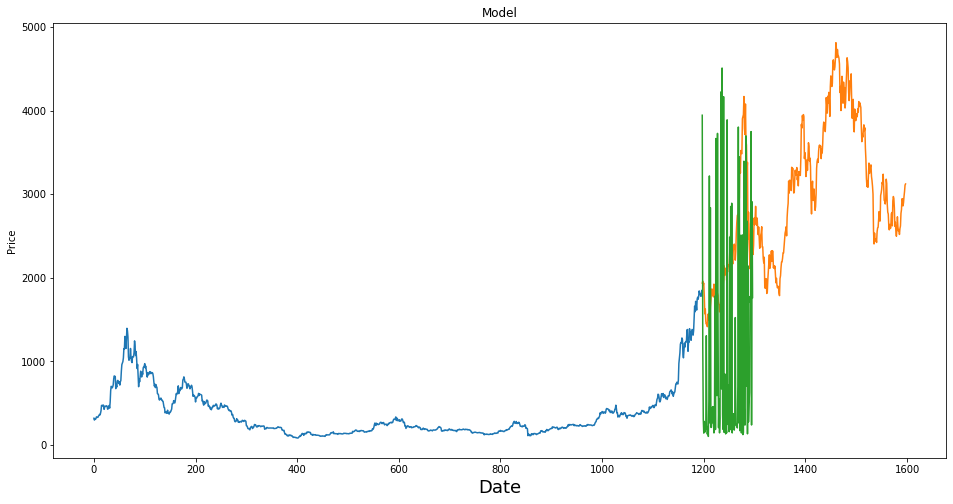

In [51]:
import matplotlib.pyplot as plt

# Plot the data
train = features[:len(X_train)][:, -2]
valid = features[len(X_train):][:, -2]

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price')
plt.plot(np.arange(len(train)), train)
plt.plot(np.arange(len(train), len(train) + len(valid)), valid)
plt.plot(np.arange(len(train), len(train) + len(predictions)), predictions)
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()